**Statistical Learning Theory. Exam Project**

# Choosing Dataset and Formulating Research Question(s)

I have checked the datasets at two famous sources ([the UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets.html), [Kaggle](https://www.kaggle.com/datasets)) but decided to build my own dataset.

My dataset is based on the content of the [habr.com](https://habr.com) site, and was built with several steps:

1. The script **get_habr_posts.py** walked through every link https://habr.com/post/<post n>, where n=[1..440000], i.e. from the very first post to the latest one, and downloaded the content at the link. For some of links, there are no articles, the site returns the 403/404 error codes. The result is a set of html files, one per each link.
    
2. Each html file was parsed and analyzed (by running the main script **run_n_batches_restart.py**), attributes of the interest were extracted from the html files for each post. The files were processed in batches of 1000 files, the result of each batch was saved to a Parquet file.

3. The set of 433 Parquet files was combined into one large data frame.

4. That single dataframe was pre-processed (see the *Preprocessing Data* chapter) to normalize the data, the result was saved in two variants: a) without the *text* field, and with the *text* field.

Interesting technical issues I have had to deal with:

1. Downloading from that lot of links took time, I had to parallelize the process but only moderate because starting with certain level of frequency (of downloading), rate of timeout errors was rapidly increased which I believe is a scheme of the site protection against DDoS attacks. Emperically, there should be no more than 3-4 threads with ~0.1s pause between subsequent calls (within a thread) to the site. This part of process took approx. 40 hours.

2. I have had to parallelize the initial processing of the html files to get the dataset in time. Unfortunately, the multiprocessing approaches with either *ipyparallel* or *ProcessPoolExecutor* did not work well because of memory exhausting issue: each executor consumed several gigabytes of memory after having processed first few thousands of html files. That aggresive memory consumption was probably due to extensive usage of html parser. Consequently, my machine (with 16Gb of RAM) stopped behaving correctly after having parsed few thousands of the html files. A workaround I applied was to run every new batch with a new Python process to force the memory release completely between batches. This part of process with 5 threads took approx. 6 hours.

# Navigation

In order to run any Python cell in the notebook, run the **Initialization** section first. It initializes required context.

After that...
- if you want to check details and examples of how the dataset was built (i.e. the data was scapped and parsed), check the content of the **Building Dataset** section,
- if you want to check details about the pre-processing of the initial dataset, check the content of the **Preprocessing Data** section,
- otherwise, go straight to the **Loading Data** and run from it and to the bottom, it loads the ready dataset and analyzes it.

# Initialization

This section runs initialization code and defines global variables.

In [257]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [282]:
import datetime as dt

import re

import logging
import os
import sys

from imp import reload

import habr
reload(habr)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import sklearn as sk
import pickle

# create the logger and set the logging level
logger = logging.getLogger('main')

if (logger.hasHandlers()):
    logger.handlers.clear()
logger.addHandler(logging.StreamHandler(sys.stdout))
logger.handlers[-1].setFormatter(logging.Formatter(fmt='%(asctime)s - %(levelname)s - %(message)s',
                                                   datefmt='%Y-%m-%d %H:%M:%S'))
logger.setLevel(logging.DEBUG)

# some global variables
# habr.dir_parsed    = 'data/'
habr.dir_processed = 'data/'

g_working_dir   = os.getcwd().replace('\\', '/') + '/'
logger.info('The working directory is "%s"' % g_working_dir)

plt.style.use('seaborn')

2018-12-28 08:18:23 - INFO - The working directory is "D:/Home.Dima/OneDrive/MASNA/github_masna/Statistical Learning Theory/Final Project/"


# ####### Preparation Phase #######

# Building Dataset

Steps to build the dataset yourself:
- create a directory to save the fetched posts, to save the parsing results,
- correct the values of dir_raw, dir_parsed in habr.py to those directory paths, 
- to get the posts, run the script get_habr_posts.py (you may wish to run it in parallel with 3-4 threads so replicate it that may times and correct the range for each copy accordingly),
- correct the Habr object created in run_one_batch.py,
- to parse the posts, run the script run_n_batches_restart.py which parses the html files and stores the result in the form of Parquet files.

Below, there are few examples of calling various parts of relevant API.

## Fetching Posts (Scrapping the Site)

An example of retrieving a set of posts from the site.

In [2]:
%%time

import time

habr_web_f = habr.Habr('web', 'https://habr.com/post/')

for i in range(434412, 434420):
    logger.debug('Getting the post number %d' % i)
    hp = habr_web_f.get_post(i, copy_to_dir=habr.dir_raw)
    time.sleep(0.1)

2018-12-28 05:02:05 - DEBUG - Getting the post number 434412
2018-12-28 05:02:06 - DEBUG - Getting the post number 434413
2018-12-28 05:02:06 - DEBUG - Getting the post number 434414
2018-12-28 05:02:07 - DEBUG - Getting the post number 434415
2018-12-28 05:02:07 - DEBUG - Getting the post number 434416
2018-12-28 05:02:08 - DEBUG - Getting the post number 434417
2018-12-28 05:02:08 - DEBUG - Getting the post number 434418
2018-12-28 05:02:08 - DEBUG - Getting the post number 434419
Wall time: 4.14 s


## Parsing Posts (Single Thread)

An example of retrieving one post (from the site) and parsing it.

In [3]:
%%time

habr_dir1 = habr.Habr('dir', habr.dir_raw)

post_no = 434412
#post_no = 772
hp = habr_dir1.get_post(post_no, copy_to_dir=habr.dir_raw)
if hp is not None:
    print(hp.get_post_info())

{'type': 'article', 'title': 'Вывоз ракеты перед стартом на Восточном', 'description': 'Накануне Нового года "Роскосмос" готовит запуск с космодрома Восточный двух спутников "Канопус-В" и попутных малых аппаратов. За три дня до старта...', 'locale': '', 'url': 'https://habr.com/post/434412/', 'keywords': 'ракеты, Роскосмос, Восточный, РКЦ Прогресс, Союз, GKLaunch', 'user': 'Zelenyikot', 'post_time': '26 декабря 2018 в 05:35', 'bookmarks': '33', 'views': '24,5k', 'comments_no': '202', 'type_label': '', 'title_html': 'Вывоз ракеты перед стартом на Восточном / Хабр', 'voting': 'Общий рейтинг 124: ↑121 и ↓3', 'app_type': 'Article', 'app_datePublished': '2018-12-26T05:35:51+03:00', 'app_dateModified': '2018-12-26T10:43:46+03:00', 'app_author_type': 'Person', 'app_author_name': 'Виталий Егоров', 'app_publisher_type': 'Organization', 'app_publisher_name': 'Habr', 'hubs': 'Космонавтика;Научно-популярное;Транспорт будущего', 'tags': 'ракеты;Роскосмос;Восточный;РКЦ Прогресс;Союз;GKLaunch', 'user

An example of processing the batch of posts built above, and getting a dataframe based on the parsing results.  

In [4]:
df = habr.process_habr_batch(habr=habr_dir1, start_id=434412, batch_size=10, batches=1)
df

2018-12-28 05:03:22.284261: the batch 0 is completed


,type,title,description,locale,url,keywords,user,post_time,bookmarks,views,...,app_publisher_name,hubs,tags,user_specialization,user_karma,user_rating,user_followers,text,post_fetch_time,post_fetch_code
434412,article,Вывоз ракеты перед стартом на Восточном,"Накануне Нового года ""Роскосмос"" готовит запус...",,https://habr.com/post/434412/,"ракеты, Роскосмос, Восточный, РКЦ Прогресс, Со...",Zelenyikot,26 декабря 2018 в 05:35,33,"24,5k",...,Habr,Космонавтика;Научно-популярное;Транспорт будущего,ракеты;Роскосмос;Восточный;РКЦ Прогресс;Союз;G...,Пользователь,"1442,2","125,9",1808,"Накануне Нового года ""Роскосмос"" готовит запус...",2018-12-28 05:02:27.161,None
434414,article,Айсберг,"Все знают, что такое айсберг – большой кусок л...",,https://habr.com/post/434414/,бизнес-программирование,nmivan,26 декабря 2018 в 09:02,22,"3,3k",...,Habr,Анализ и проектирование систем;Карьера в IT-ин...,бизнес-программирование,Пользователь,"255,5","823,7",1335,"Все знают, что такое айсберг – большой кусок л...",2018-12-28 05:02:07.373,None
434416,article,Почитать на каникулах. Лучшие посты в нашем бл...,"Привет! Грядут новогодние каникулы, а с ними и...",,https://habr.com/company/2gis/blog/434416/,"2гис, микросервисы, программирование, frontend...",InnaSavchkova,вчера в 07:11,70,"5,7k",...,Habr,Блог компании 2ГИС;Программирование;Управление...,2гис;микросервисы;программирование;frontend;lt...,Developer Relations,"22,5","77,6",3,"Привет! Грядут новогодние каникулы, а с ними и...",2018-12-28 05:02:08.292,None


## Parsing Posts (Multiple Threads with iPython Clusters)

An example of processing posts concurrently:
- start the iPython cluster workers with ipcluster start,
- run the code below

In [ ]:
from ipyparallel import Client

rc = Client()
dv = rc[:]

def call_process_habr_batch(start_id, batch_size, batches):
    
    import sys
    sys.path.append(g_working_dir)
    
    from imp import reload
    import habr
    reload(habr)
    
    habr_dir1 = habr.Habr('dir', habr.dir_raw)
    #habr_ssh  = habr.Habr('ssh', 'dmdp@192.168.1.2:/mnt/data_1/Temp/_cache3')

    df = habr.process_habr_batch(habr=habr_ssh, 
                                 start_id=start_id, 
                                 batch_size=batch_size, 
                                 batches=1, 
                                 output_dir=habr.dir_parsed)
    
    return('Has successfully built the dataframe of the shape %s for %d, %d, %d' % 
           (str(df.shape), start_id, batch_size, batches))

start_id_list   = list(range(434412, 434420, 3))
batch_size_list = [3] * len(start_id_list)

res = dv.map(call_process_habr_batch, start_id_list, batch_size_list)
print(res.get())

## Combining Parsed Files into One

In [10]:
# reading the Parquet files and combining them into one dataframe
fn_list = [habr.dir_parsed + fn for fn in os.listdir(habr.dir_parsed) if re.match(habr.fn_parsed_parquet_pattern, fn)]

logger.debug('Found %d Parquet files in the source directory' % len(fn_list))

if len(fn_list) > 0:

    df_list = []

    for fn in fn_list:
    # for fn in fn_list[:3] + fn_list[-3:]:
        logger.debug('Reading the file %s' % fn)    
        dft = pd.read_parquet(fn)
        df_list.append(dft)

    dfhp = pd.concat(df_list, sort=False)

    logger.info('Created the dataframe of the shape %s' % str(dfhp.shape))

2018-12-28 05:06:57 - DEBUG - Found 433 Parquet files in the source directory
2018-12-28 05:06:57 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_000000-000999.parquet
2018-12-28 05:06:58 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_001000-001999.parquet
2018-12-28 05:06:58 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_002000-002999.parquet
2018-12-28 05:06:58 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_003000-003999.parquet
2018-12-28 05:06:58 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_004000-004999.parquet
2018-12-28 05:06:58 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_005000-005999.parquet
2018-12-28 05:06:58 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_006000-006999.parquet
2018-12-28 05:06:58 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_007000-007999.parquet
2018-12-28 05:06:58 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_008000-008999.par

2018-12-28 05:07:03 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_081000-081999.parquet
2018-12-28 05:07:03 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_082000-082999.parquet
2018-12-28 05:07:03 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_083000-083999.parquet
2018-12-28 05:07:03 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_084000-084999.parquet
2018-12-28 05:07:03 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_085000-085999.parquet
2018-12-28 05:07:03 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_086000-086999.parquet
2018-12-28 05:07:04 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_087000-087999.parquet
2018-12-28 05:07:04 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_088000-088999.parquet
2018-12-28 05:07:04 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_089000-089999.parquet
2018-12-28 05:07:04 - DEBUG - Reading the file D:/Temp/02_habr_parsed/hab

2018-12-28 05:07:11 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_161000-161999.parquet
2018-12-28 05:07:11 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_162000-162999.parquet
2018-12-28 05:07:11 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_163000-163999.parquet
2018-12-28 05:07:11 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_164000-164999.parquet
2018-12-28 05:07:11 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_165000-165999.parquet
2018-12-28 05:07:11 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_166000-166999.parquet
2018-12-28 05:07:11 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_167000-167999.parquet
2018-12-28 05:07:11 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_168000-168999.parquet
2018-12-28 05:07:11 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_169000-169999.parquet
2018-12-28 05:07:11 - DEBUG - Reading the file D:/Temp/02_habr_parsed/hab

2018-12-28 05:07:14 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_241000-241999.parquet
2018-12-28 05:07:14 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_242000-242999.parquet
2018-12-28 05:07:14 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_243000-243999.parquet
2018-12-28 05:07:14 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_244000-244999.parquet
2018-12-28 05:07:14 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_245000-245999.parquet
2018-12-28 05:07:14 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_246000-246999.parquet
2018-12-28 05:07:14 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_247000-247999.parquet
2018-12-28 05:07:14 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_248000-248999.parquet
2018-12-28 05:07:14 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_249000-249999.parquet
2018-12-28 05:07:14 - DEBUG - Reading the file D:/Temp/02_habr_parsed/hab

2018-12-28 05:07:18 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_321000-321999.parquet
2018-12-28 05:07:18 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_322000-322999.parquet
2018-12-28 05:07:18 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_323000-323999.parquet
2018-12-28 05:07:18 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_324000-324999.parquet
2018-12-28 05:07:18 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_325000-325999.parquet
2018-12-28 05:07:18 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_326000-326999.parquet
2018-12-28 05:07:18 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_327000-327999.parquet
2018-12-28 05:07:18 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_328000-328999.parquet
2018-12-28 05:07:18 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_329000-329999.parquet
2018-12-28 05:07:18 - DEBUG - Reading the file D:/Temp/02_habr_parsed/hab

2018-12-28 05:07:22 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_401000-401999.parquet
2018-12-28 05:07:22 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_402000-402999.parquet
2018-12-28 05:07:22 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_403000-403999.parquet
2018-12-28 05:07:22 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_404000-404999.parquet
2018-12-28 05:07:22 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_405000-405999.parquet
2018-12-28 05:07:22 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_406000-406999.parquet
2018-12-28 05:07:22 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_407000-407999.parquet
2018-12-28 05:07:22 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_408000-408999.parquet
2018-12-28 05:07:22 - DEBUG - Reading the file D:/Temp/02_habr_parsed/habr_posts_409000-409999.parquet
2018-12-28 05:07:22 - DEBUG - Reading the file D:/Temp/02_habr_parsed/hab

In [11]:
dfhp.shape

(207821, 33)

In [12]:
dfhp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207821 entries, 1 to 434500
Data columns (total 33 columns):
type                   207821 non-null object
title                  207821 non-null object
description            207821 non-null object
locale                 207821 non-null object
url                    207821 non-null object
keywords               207821 non-null object
user                   207821 non-null object
post_time              207821 non-null object
bookmarks              207821 non-null object
views                  207821 non-null object
comments_no            207821 non-null object
type_label             207821 non-null object
title_html             207818 non-null object
voting                 207821 non-null object
app_type               206826 non-null object
app_datePublished      206826 non-null object
app_dateModified       206826 non-null object
app_author_type        206826 non-null object
app_author_name        206826 non-null object
app_publisher_t

In [13]:
# saving the whole dataset into one file
file_name = 'habr_posts_all_%06d-%06d.parquet' % (dfhp.index.min(), dfhp.index.max())
dfhp.to_parquet(habr.dir_parsed + file_name, compression='gzip')

# saving the whole dataset into one file (without 'text')
#file_name = 'habr_posts_%06d-%06d_no_text.parquet' % (dfhp.index.min(), dfhp.index.max())
#dfhp[dfhp.columns.difference(['text'])].to_parquet(habr.dir_processed + file_name, compression='gzip')

# Preprocessing data

You need to show that you understand correctly how the data should be preprocessed, i.e. what to do with categorical data, missing values etc. I ask you to explain why you did this very preprocessing (take into account that preprocessing often depends on model type)

<b>Total:</b> <i>2 points</i>

## Loading Dataset (Parsed Posts)

In [3]:
%%time

dfhp = pd.read_parquet(habr.dir_parsed + 'habr_posts_all_000001-434500.parquet')

print(dfhp.shape)

(207821, 33)
Wall time: 20.6 s


Checking if there are batches with a lot of posts with missing 'app_datePublished', it may be an indicator these posts need to be reloaded and reparsed.

In [4]:
# finding range which largely miss 'app_datePublished', they should probably be reloaded

dft = 1000*(dfhp[dfhp['app_datePublished'].isna()].index / 1000).astype('int')\
    .to_frame().rename(columns={0:'start_id'})

dft.groupby('start_id').size()[dft.groupby('start_id').size() >= 10]

start_id
21000     13
22000     14
52000     10
64000     11
137000    11
146000    10
dtype: int64

There are not so many batches with the missing *app_datePublished*, proceeding.

## Renaming
Some renaming to make the columns' name to be more representative to their content.

In [5]:
dfhp.rename(columns={'user_specialization': 'author_specialization', 
                     'user_karma':  'author_karma',
                     'user_rating': 'author_rating',
                     'user_followers': 'author_followers'}, inplace=True)

dfhp.rename(columns={'app_dateModified': 'updated_at', 'post_fetch_time': 'scrapped_at', 'comments_no': 'comments_num'}, inplace=True)

### Obvious Type Conversion

In [6]:
dfhp['app_datePublished'] = pd.to_datetime(dfhp['app_datePublished'])
dfhp['updated_at']        = pd.to_datetime(dfhp['updated_at'])

# these dates seem to be in the UTC timezone, converting them to the Moscow one so as to compare with post_date in the naive way
dfhp['app_datePublished'] = dfhp['app_datePublished'].dt.tz_localize('UTC').dt.tz_convert('Europe/Moscow').dt.tz_localize(None)
dfhp['updated_at']        = dfhp['updated_at'].dt.tz_localize('UTC').dt.tz_convert('Europe/Moscow').dt.tz_localize(None)

In [7]:
dfhp['bookmarks'] = dfhp['bookmarks'].astype('int')

In [8]:
dfhp['comments_num'] = pd.to_numeric(dfhp['comments_num'])

In [9]:
# converting the user rating from the string data type to the numeric one
dfhp['author_rating'] = dfhp['author_rating'].str.replace(',', '.').str.replace('–', '-').astype('float')

In [10]:
dfhp['type_label'] = dfhp['type_label'].astype('category')
dfhp.groupby('type_label').size()

type_label
            180441
Tutorial      7641
Из RSS        1371
Новость       2668
Перевод      15700
dtype: int64

In [11]:
dfhp['author_karma'] = dfhp['author_karma'].str.replace(',', '.').astype('float')

In [12]:
dfhp['author_followers'] = dfhp['author_followers'].astype('float')

In [15]:
# user votes, they are originally parsed as '390 голосов'
dfhp['user_votes'] = dfhp['user_votes'].str.extract('([0-9]+)').astype('float')

## Info

In [13]:
dfhp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207821 entries, 1 to 434500
Data columns (total 33 columns):
type                     207821 non-null object
title                    207821 non-null object
description              207821 non-null object
locale                   207821 non-null object
url                      207821 non-null object
keywords                 207821 non-null object
user                     207821 non-null object
post_time                207821 non-null object
bookmarks                207821 non-null int32
views                    207821 non-null object
comments_num             192429 non-null float64
type_label               207821 non-null category
title_html               207818 non-null object
voting                   207821 non-null object
app_type                 206826 non-null object
app_datePublished        206826 non-null datetime64[ns]
updated_at               206826 non-null datetime64[ns]
app_author_type          206826 non-null object
app_aut

## Data with no Variance

Checking some attributes for range of unique values.

In [14]:
col_names = ['locale', 'type', 'app_type', 'app_author_type', 'app_publisher_type', 'post_fetch_code']

dfhp[col_names].describe()

,locale,type,app_type,app_author_type,app_publisher_type,post_fetch_code
count,207821,207821,206826,206826,206826,0.0
unique,2,1,1,1,1,0.0
top,ru_RU,article,Article,Person,Organization,NaN
freq,207819,207821,206826,206826,206826,NaN


All of those columns have only one value so they can be dropped from the dataset?

## Authorship

In [16]:
dfhp[dfhp['app_author_name'] != dfhp['user']][['user', 'app_author_name']].head(5)

,user,app_author_name
1,deniskin,Денис Крючков
2,geraxe,Юрий Баландин
3,deniskin,Денис Крючков
4,deniskin,Денис Крючков
6,deniskin,Денис Крючков


In [17]:
dfhp.rename(columns={'user': 'author_nickname',
                     'app_author_name': 'author_name',
                     'app_publisher_name': 'author_org'}, inplace=True)

## Title

In [18]:
dfhp[['title', 'title_html']].head(5)

,title,title_html
1,Wiki-FAQ для Хабрахабра,Wiki-FAQ для Хабрахабра / Хабр
2,Мы знаем много недоделок на сайте… но!,Мы знаем много недоделок на сайте… но! / Хабр
3,Чтение RSS-потоков,Чтение RSS-потоков / Хабр
4,"Маслов, Сокур и партнеры пиарят Google в России","Маслов, Сокур и партнеры пиарят Google в Росси..."
6,Подкасты на Хабрахабре,Подкасты на Хабрахабре / Хабр


## Normalizing Publishing Timestamp

There are two sources for the post time: post_time, app_datePublished (in the Moscow time zone). The preferrable one is the second one but it is missed for some posts. For these cases, I rely on timestamps from post_time which are in a human reading format.

The code below converges and converts these two fields below to the timestamp datatype.

In [19]:
print(dfhp[['post_time', 'app_datePublished']].iloc[[0,1,2, -3,-2,-1]])
print()
print(dfhp[dfhp['app_datePublished'].isnull()][['post_time', 'app_datePublished']].head(5))

                      post_time   app_datePublished
1          13 июля 2006 в 18:23 2006-07-13 18:23:39
2          14 июля 2006 в 00:45 2006-07-14 00:45:38
3          14 июля 2006 в 01:13 2006-07-14 01:13:38
434496          сегодня в 22:52 2018-12-26 22:52:03
434498  26 декабря 2018 в 22:56 2018-12-26 22:56:20
434500          сегодня в 03:26 2018-12-28 03:26:03

                    post_time app_datePublished
772    1 декабря 2006 в 20:44               NaT
2855   3 февраля 2007 в 03:05               NaT
2858   3 февраля 2007 в 04:54               NaT
2860   3 февраля 2007 в 04:55               NaT
5745    25 марта 2007 в 17:25               NaT


In [27]:
month_translation = {'января': 1, 'февраля': 2, 'марта':    3, 'апреля':   4, 'мая':     5, 'июня':     6,
                     'июля':   7, 'августа': 8, 'сентября': 9, 'октября': 10, 'ноября': 11, 'декабря': 12}

def normalize_habr_date(x):
    
    post_time = x['post_time'].strip()
    date = np.nan
    
    if pd.isnull(post_time) or post_time == '':

        return(date)
    
    if post_time[0].isdigit():
        
        m = re.match('^(?P<day>[0-9]{1,2})\ (?P<month>.+?)\ (?P<year>[0-9]{4}) в (?P<hour>[0-9]{1,2}):(?P<minute>[0-9]{1,2})', post_time)
        
        if m:
            
            day    = int(m.group('day'))
            month  = month_translation[m.group('month')]
            year   = int(m.group('year'))
            hour   = int(m.group('hour'))
            minute = int(m.group('minute'))
            
            #date = dt.datetime.strptime('%s-%s-%s %s:%s' % (year, month, day, hour, minute), '%Y-%m-%d %H:%M')
            date = dt.datetime(year, month, day, hour, minute)
    
    elif post_time[0].isalpha():
        
        m = re.match('^(?P<when>.+)\ в (?P<hour>[0-9]{1,2}):(?P<minute>[0-9]{1,2})', post_time)
        
        if m:
            
            hour   = int(m.group('hour'))
            minute = int(m.group('minute'))
            date_0 = x['scrapped_at']
            
            if m.group('when') == 'вчера':    
                date_0 = date_0 - dt.timedelta(days=1)
                
            day    = date_0.day
            month  = date_0.month
            year   = date_0.year
            
            date = dt.datetime(year, month, day, hour, minute)
                
    else:
        
        raise ValueError('Unknown date format')
                
    return(date)
    
dfhp['published_at'] = dfhp.apply(lambda x: x['app_datePublished'] if pd.notnull(x['app_datePublished']) else normalize_habr_date(x), axis=1)

## Normalizing Number of Views

In [26]:
# normalizing the number of views as for the number of views over 1000 there is the 'k' qualifier
# the number of all views are to the base of 1 thousand

def normalize_view_number(views):
    
    res = None
    
    v = views.strip().replace(',', '.')
    
    if v[-1] == 'k':
        res = float(v[:-1])
    else:
        res = round(float(v) / 1000,1)

    return(res)

dfhp['views_thou'] = dfhp['views'].apply(lambda x: normalize_view_number(x))

## Voting

There are negative votes and positive votes, getting them from a string format and converting to numbers.

In [23]:
# an example

print(dfhp[dfhp['voting'].notnull()]['voting'].iloc[[0,1,2, -3,-2,-1]])

1         Общий рейтинг 1: ↑1 и ↓0
2         Общий рейтинг 0: ↑0 и ↓0
3         Общий рейтинг 1: ↑1 и ↓0
434496    Общий рейтинг 0: ↑0 и ↓0
434498    Общий рейтинг 9: ↑7 и ↓2
434500    Общий рейтинг 2: ↑2 и ↓0
Name: voting, dtype: object


In [20]:
def parse_voting(v):
    
    votes_pos = np.nan
    votes_neg = np.nan
    
    if pd.notnull(v) and v != '':

        m = re.match('^Общий рейтинг.+↑(?P<votes_pos>[0-9]+)\ и\ ↓(?P<votes_neg>[0-9]+)', v)
        
        if m:
            
            votes_pos = int(m.group('votes_pos'))
            votes_neg = int(m.group('votes_neg'))
            
    return(votes_pos, votes_neg)

dfhp['votes_pos'], dfhp['votes_neg'] = zip(*dfhp['voting'].map(parse_voting))

## Info of Original Source

In [24]:
# Extracting the name of author of original article

dfhp['original_author'] = dfhp['translation_title'].str.extract('Автор оригинальной публикации: (.+)').fillna('')

In [22]:
dfhp.rename(columns={'translation_link': 'original_link'}, inplace=True)

## Segregating the Keywords

In [25]:
# TBC

## Segregating the Hub Names

In [21]:
# TBC

## Saving Pre-Processed Data

In [28]:
dfhp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207821 entries, 1 to 434500
Data columns (total 38 columns):
type                     207821 non-null object
title                    207821 non-null object
description              207821 non-null object
locale                   207821 non-null object
url                      207821 non-null object
keywords                 207821 non-null object
author_nickname          207821 non-null object
post_time                207821 non-null object
bookmarks                207821 non-null int32
views                    207821 non-null object
comments_num             192429 non-null float64
type_label               207821 non-null category
title_html               207818 non-null object
voting                   207821 non-null object
app_type                 206826 non-null object
app_datePublished        206826 non-null datetime64[ns]
updated_at               206826 non-null datetime64[ns]
app_author_type          206826 non-null object
author_

In [29]:
col_names = ['author_nickname', 'author_name', 'author_org',
      'title', 'title_html', 'description', 'url',
      'type_label', 'original_author', 'original_link',
      'views_thou', 'bookmarks', 'comments_num',
      'votes_pos', 'votes_neg', 'user_votes',
      'author_specialization', 'author_karma', 'author_rating', 'author_followers',
      'published_at', 'updated_at', 'scrapped_at',
      'hubs', 'tags', 'keywords']

# saving the whole dataset into one file
file_name = 'habr_posts_%06d-%06d.normalized.parquet' % (dfhp.index.min(), dfhp.index.max())
dfhp[col_names + ['text']].to_parquet(habr.dir_processed + file_name, compression='gzip')

file_name = 'habr_posts_%06d-%06d.no_text.normalized.parquet' % (dfhp.index.min(), dfhp.index.max())
dfhp[col_names].to_parquet(habr.dir_processed + file_name, compression='gzip')

# ####### Analysis and Modelling Phase #######

# Loading Data

The dataset is available at the link https://1drv.ms/u/s!AtKO7dPNHthwhbVxO4kxiN3qid9ymQ, it is of ~50Mb.

In [348]:
dfhp = pd.read_parquet(habr.dir_processed + 'habr_posts_000001-434500.no_text.normalized.parquet')

In [31]:
dfhp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207821 entries, 1 to 434500
Data columns (total 26 columns):
author_nickname          207821 non-null object
author_name              206826 non-null object
author_org               206826 non-null object
title                    207821 non-null object
title_html               207818 non-null object
description              207821 non-null object
url                      207821 non-null object
type_label               207821 non-null object
original_author          207821 non-null object
original_link            15702 non-null object
views_thou               207821 non-null float64
bookmarks                207821 non-null int32
comments_num             192429 non-null float64
votes_pos                206958 non-null float64
votes_neg                206958 non-null float64
user_votes               957 non-null float64
author_specialization    207821 non-null object
author_karma             191595 non-null float64
author_rating           

## Authors DataFrame

Creating a separate data frame for the authors to keep some statistics about them.

In [32]:
dfa = dfhp[['author_nickname', 'author_name', 'author_org', 'author_specialization']].drop_duplicates().sort_values('author_nickname')

There are only minor set of authors which tend to change their other attributes (author_name, author_org, author_specialization), let''s drop them.

In [34]:
dfa.groupby('author_nickname').filter(lambda x: len(x) > 1).shape

(629, 4)

In [176]:
dfa = dfhp[['author_nickname']].drop_duplicates().sort_values('author_nickname')

# removing the empty name
dfa = dfa[dfa['author_nickname'] != ''].set_index('author_nickname')

dfa.shape

(34320, 0)

# Adding Features

In [121]:
# the domain of the original material
dfhp['original_link_domain'] = dfhp['original_link'].str.extract('http[s]{0,1}:\/\/(.+?)\/')

In [122]:
# the indicator that the material was translated
dfhp['is_translated'] = dfhp['type_label'] == 'Перевод'

## Authors

In [177]:
dft = dfhp.groupby('author_nickname')\
                .agg({'published_at': {min, max}, 
                      'title': {'count'},
                      'is_translated': {sum},
                      'views_thou': {sum},
                      'comments_num': {sum},
                      'author_karma': {max},
                      'author_rating': {max},
                      'author_followers': {max},
                     })

dft.columns = ['_'.join(col) for col in dft.columns]
#dft.columns = dft.columns.droplevel(1)
dft.rename(columns={'author_karma_max': 'author_karma', 
                    'author_rating_max': 'author_rating',
                    'author_followers_max': 'author_followers'}, inplace=True)

In [178]:
# first and last published dates per author
dfa = dfa.join(dft, how='left')

In [179]:
# rate of publishing for an author
dfa['history_days']    = (dfa['published_at_max'] - dfa['published_at_min']).dt.days
dfa['publishing_rate'] = dfa['history_days'] / dfa['title_count']
dfa['publishing_rate'] = dfa['publishing_rate'].apply(lambda x: np.nan if x == 0 else x)

In [180]:
# number of views of article

In [181]:
# stats for one of popular author|
dfa.loc['alizar']

published_at_max     2018-12-26 20:18:24
published_at_min     2006-06-06 17:41:00
title_count                         8318
is_translated_sum                    185
views_thou_sum                    126961
comments_num_sum                  518596
author_karma                       826.5
author_rating                     1201.7
author_followers                    1298
history_days                        4586
publishing_rate                 0.551334
Name: alizar, dtype: object

## Reaction Ratio

The number of bookmarks, comments, votes etc to the number of views of a post can be considered as an indicator of how well the post causes people to react to it.

## Ambiguity

Posts may receive high number of positive votes and as well as high number of negative votes

# EDA

## Most Popular Authors

By absolute number of posts

In [41]:
dfa.sort_values('posts_num', ascending=False).head(10)

,author_nickname,published_at_max,published_at_min,posts_num,history_days,publishing_rate
14977,alizar,2018-12-26 20:18:24,2006-06-06 17:41:00,8318,4586.0,0.551334
24797,marks,2018-12-26 14:44:21,2010-01-13 23:32:42,6611,3268.0,0.494328
10578,SLY_G,2018-12-26 15:00:02,2010-12-31 20:24:45,2963,2916.0,0.984138
22314,ivansychev,2018-09-21 09:49:00,2010-04-05 13:29:20,1485,3090.0,2.080808
28866,rssbot,2013-08-28 15:54:52,2008-09-19 10:18:38,1371,1804.0,1.315828
29444,semen_grinshtein,2017-06-16 17:12:22,2015-02-09 21:53:48,1291,857.0,0.663826
22514,jeston,2016-09-05 07:21:42,2011-01-02 18:59:39,1091,2072.0,1.899175
13525,XaocCPS,2016-06-14 19:43:57,2008-05-05 08:31:46,999,2962.0,2.964965
12539,Tylerskald,2011-04-01 14:49:18,2007-06-20 18:46:59,919,1380.0,1.501632
11127,Shapelez,2018-11-27 15:02:31,2008-03-29 21:26:11,817,3894.0,4.766218


By the publishing rate for those who have the history over 1 year

In [42]:
dfa[dfa['history_days'] >= 365].sort_values('publishing_rate', ascending=True).head(10)

,author_nickname,published_at_max,published_at_min,posts_num,history_days,publishing_rate
24797,marks,2018-12-26 14:44:21,2010-01-13 23:32:42,6611,3268.0,0.494328
14977,alizar,2018-12-26 20:18:24,2006-06-06 17:41:00,8318,4586.0,0.551334
29444,semen_grinshtein,2017-06-16 17:12:22,2015-02-09 21:53:48,1291,857.0,0.663826
22641,julia,2008-04-29 14:31:30,2006-07-03 14:04:00,755,666.0,0.882119
10578,SLY_G,2018-12-26 15:00:02,2010-12-31 20:24:45,2963,2916.0,0.984138
8293,Mordatyj,2010-08-12 17:44:34,2008-09-12 17:52:16,631,698.0,1.106181
28866,rssbot,2013-08-28 15:54:52,2008-09-19 10:18:38,1371,1804.0,1.315828
12539,Tylerskald,2011-04-01 14:49:18,2007-06-20 18:46:59,919,1380.0,1.501632
22514,jeston,2016-09-05 07:21:42,2011-01-02 18:59:39,1091,2072.0,1.899175
24488,m1rko,2018-12-26 22:52:03,2016-12-14 20:12:43,364,742.0,2.038462


## Publishing Rate

Publishing rate = the average number of days between posts

In [ ]:
x = dft[(dft['reg_channel'] == 'KM') & (dft['reg_visit_diff_min'] <= 720)]['reg_visit_diff_min']
sns.kdeplot(x, shade=True, color="b", label = 'KM', ax = axs[0])
axs[0].set_xlim(0, 12 * 60)
axs[0].set_xticks([day_no * 60 for day_no in range(13)])
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=70)
axs[0].set_xlabel('The ''onboardng'' time, minutes')
axs[0].set_ylabel('$p(x)$')


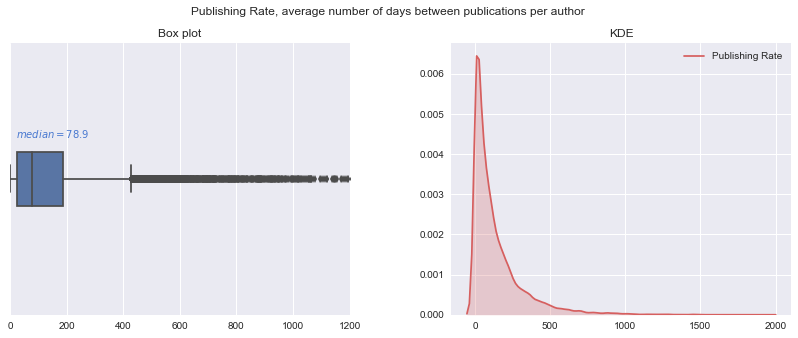

In [260]:
import matplotlib.gridspec as gridspec

fig, axs = plt.subplots(figsize = (14, 5), ncols=2)

gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
axs[0] = plt.subplot(gs[0])
axs[1] = plt.subplot(gs[1])

# Data
x = dfa[dfa['publishing_rate'] > 0]['publishing_rate']

# Boxplot
sns.boxplot(ax=axs[0], x=x, width=0.2)
axs[0].set_title('Box plot')
axs[0].set_xlabel(None)

#axs[0].set_xscale("log")
axs[0].set_xlim(0, 1200)

for tick, label in zip(range(1), axs[0].get_yticklabels()):
    axs[0].text(20, tick - 0.15, '$median=%.1f$' % x.median(), 
            horizontalalignment='left', size='medium', color='b')

# KDE
sns.kdeplot(ax=axs[1], data=x, shade=True, color="r", label='Publishing Rate')
axs[1].set_title('KDE')

# Common
fig.suptitle('Publishing Rate, average number of days between publications per author')
fig.subplots_adjust(wspace=0.3)
   
# saving the graph
file_base_name = 'distr_publishing_rate_kde'
plt.savefig('graphs/' + file_base_name + '.pdf', bbox_inches='tight') 

## Rate of Translated Materials

In [81]:
dfhp_by_year_groupper = dfhp.groupby(dfhp['published_at'].dt.year)['is_translated']
dfhp_by_year = dfhp_by_year_groupper.apply(lambda x: round(100*(x == True).sum()/len(x), 1))

In [82]:
dfhp_by_year = dfhp_by_year.to_frame().rename(columns={'is_translated': 'translated_publ_rate_pct'})\
    .join(dfhp_by_year_groupper.size().to_frame().rename(columns={'is_translated': 'all_posts'}))\
    .join(dfhp_by_year_groupper.apply(lambda x: (x == True).sum()).to_frame().rename(columns={'is_translated': 'translated_posts'}))

dfhp_by_year.index.name = 'year'
dfhp_by_year.index = dfhp_by_year.index.astype('int')

In [83]:
dfhp_by_year[['all_posts', 'translated_posts', 'translated_publ_rate_pct']]

,all_posts,translated_posts,translated_publ_rate_pct
year,,,
2006,3020,30,1.0
2007,12806,418,3.3
2008,16092,558,3.5
2009,18024,722,4.0
2010,17815,912,5.1
2011,16689,986,5.9
2012,16687,874,5.2
2013,15857,1002,6.3
2014,16184,1246,7.7


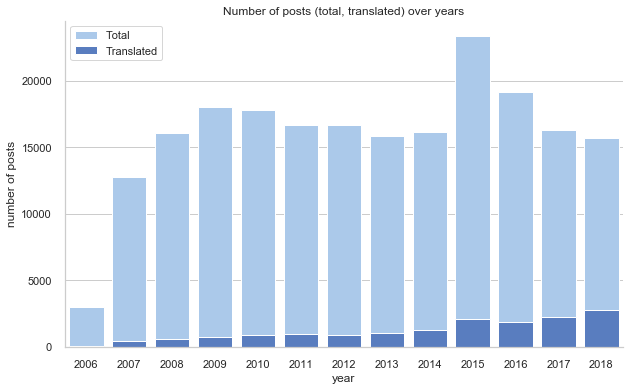

In [263]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize = (10, 6))

# total number of posts
sns.set_color_codes("pastel")
sns.barplot(x='year', y='all_posts', data=dfhp_by_year.reset_index(), label="Total", color="b")

# number of translated posts
sns.set_color_codes("muted")
sns.barplot(x='year', y='translated_posts', data=dfhp_by_year.reset_index(), label="Translated"
            , color="b")

ax.set_ylabel('number of posts')

# annotating the bars
#for i, r in dfhp_by_year.iterrows():
#    ax.text(r.name, r['all_posts'], '%2.1f' % r['translated_publ_rate_pct']) #, color='black', ha="center")

ax.legend(ncol=1, loc="upper left", frameon=True)
sns.despine(top=True, right=True)
ax.set_title('Number of posts (total, translated) over years')

# saving the graph
file_base_name = 'translated_publ_rate'
plt.savefig('graphs/' + file_base_name + '.pdf', bbox_inches='tight')

In [265]:
plt.style.use('seaborn')

## Ambiguity

In [23]:
# scatterplot

# Model - Authors

Let's try to find out how different the authors are by clustering and finding principal components for them.

In [274]:
# the authors' data's subset to use for the model
dfa_m = dfa[['title_count', 'is_translated_sum', 'views_thou_sum', 'comments_num_sum', 
     'author_karma', 'author_rating', 'author_followers', 'history_days', 'publishing_rate']].fillna(0)

## Clusters of Authors

Let's try to find how many clusters of authors there could be. Using the K-means algorythm.

In [283]:
from sklearn.cluster import KMeans

# inertia for various number of clusters
inertia = {}
kmeans_iter = 3

for k in range(1, 12):
    
    # running several iterations for each k to get an average inertia
    
    inertia_sum = 0
    
    for i in range(kmeans_iter):
        
        m = KMeans(n_clusters=k, n_jobs=4).fit(dfa_m)
        inertia_sum += m.inertia_
        
    inertia[k] = inertia_sum/kmeans_iter
    
    # saving the model for the selected k
    if k == 6:
        with open('models/authors_kmeans_%d.pkl' % k, 'wb') as f:
            pickle.dump(m, f)

In [284]:
df_inertia = pd.DataFrame.from_dict(inertia, orient='index')
df_inertia.rename(columns={'index':'k', 0: 'inertia'}, inplace=True)
df_inertia.index.name = 'k'
df_inertia['inertia_sqrt'] = np.sqrt(df_inertia['inertia'])
df_inertia['inertia_log']  = np.log(df_inertia['inertia'])
df_inertia

,inertia,inertia_sqrt,inertia_log
k,,,
1,4.514663e+11,671912.447590,26.835767
2,1.024098e+11,320015.277176,25.352248
3,7.158182e+10,267547.795902,24.994107
4,4.447880e+10,210899.981070,24.518279
5,3.082426e+10,175568.401362,24.151568
6,1.905442e+10,138037.761417,23.670565
7,1.293230e+10,113720.280491,23.282994
8,1.041634e+10,102060.485855,23.066642
9,8.393689e+09,91617.079010,22.850746


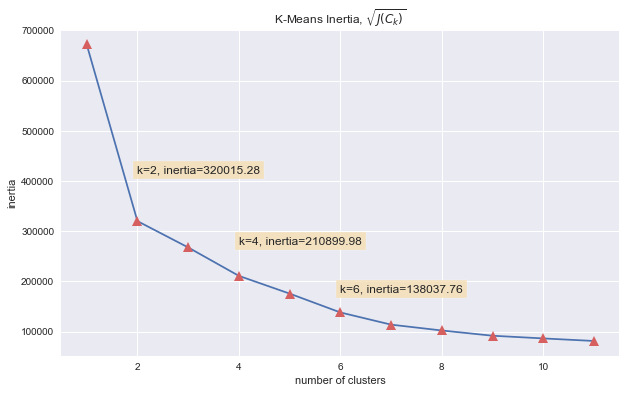

In [285]:
fig, ax = plt.subplots(figsize = (10, 6), ncols=1)

inertia_field = 'inertia_sqrt'

plt.plot(df_inertia.index, df_inertia[inertia_field], marker='^', markersize=10, markerfacecolor='r')
ax.set_title('K-Means Inertia, $\sqrt{J(C_k)}$')
ax.set_xlabel('number of clusters')
ax.set_ylabel('inertia')

#ax.legend(['Inertia')
for k in [2, 4, 6]:
    
    inertia_k = df_inertia.loc[k,inertia_field] 
    #ax.plot([k, k], [0.9*inertia_k, 1.1*inertia_k], 'k-', color='red', lw=2)
    
    ax.text(k, inertia_k*1.3,
            'k=%d, inertia=%.2f' % (k, inertia_k), 
            bbox=dict(facecolor='wheat', alpha=0.8, zorder = 10))

file_base_name = 'clust_kmeans_inertia'
plt.savefig('graphs/' + file_base_name + '.svg', bbox_inches='tight')

The optimal number of clusters (based on the inertia decreasing slope) seems to be 4-6. Let''s select k=6.

## PCA

In [305]:
from sklearn import decomposition

pca = decomposition.PCA()
pca.fit(dfa_m)

print('Percentage of variance explained by each of the components: %s' % pca.explained_variance_ratio_)
print('Estimated number of components: %d' % pca.n_components_)

Percentage of variance explained by each of the components: [9.56554659e-01 3.52029985e-02 7.13005807e-03 8.89163006e-04
 1.22011171e-04 4.54311093e-05 3.38542465e-05 1.73700714e-05
 4.45443929e-06]
Estimated number of components: 9


It looks like there is no much variance? It's probably enough to get away with just one or two components.

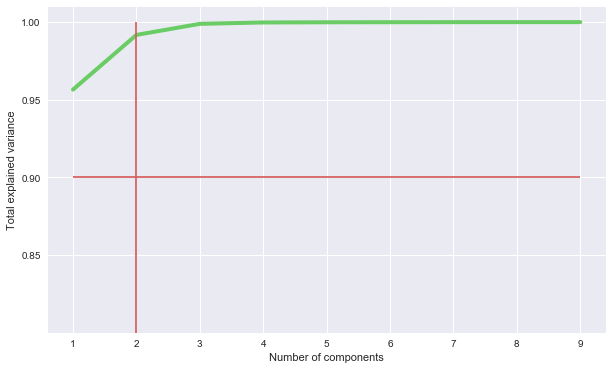

In [329]:
fig, ax = plt.subplots(figsize = (10, 6), ncols=1)

plt.plot(range(1,len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), color='g', lw=4, zorder=1)
ax.set_ylim(0.8, 1.01)
ax.set_yticks(np.arange(0.85, 1.00, 0.05))
ax.set_xlabel('Number of components')
ax.set_ylabel('Total explained variance')
ax.hlines(0.9, 1, len(pca.explained_variance_ratio_), color='r')
ax.vlines(2,   0, 1, color='r')

#ax.set_title('PCA')

file_base_name = 'pca'
plt.savefig('graphs/' + file_base_name + '.svg', bbox_inches='tight')

Drawing the scatterplot for the selected number of components and the selected number of clusters

In [332]:
# Let's take the two first components
pca.n_components = 2
dfa_m_reduced  = pca.fit_transform(dfa_m)

# loading the saved k-means model and finding coordinates of the centroids
with open('models/authors_kmeans_6.pkl', 'rb') as f:
    mk = pickle.load(f)
author_centers = pca.transform(mk.cluster_centers_)

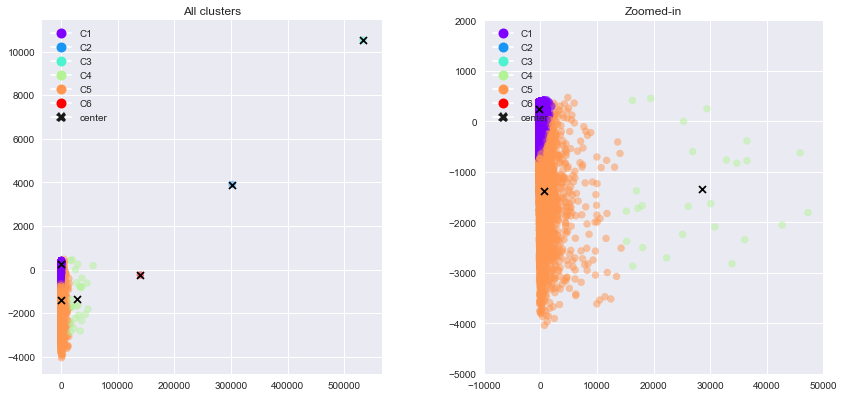

In [346]:
from matplotlib.lines import Line2D
from matplotlib.cm import rainbow
        
def plot_pca2(ax, zoomed_in=False):
    
    # Make a scatter plot
    x = np.hsplit(dfa_m_reduced, 2)[0]
    y = np.hsplit(dfa_m_reduced, 2)[1]

    colormap = rainbow(np.linspace(0, 1, mk.n_clusters))

    plt.scatter(x=x, y=y, c=colormap[mk.labels_], alpha=0.5)

    #PCA colored according to the k-Means cluster labels

    # centers
    plt.scatter(x = np.hsplit(author_centers, 2)[0], y = np.hsplit(author_centers, 2)[1], c = 'black', marker='x')

    #ax1.set_xlim(-5, 15)
    #ax1.set_ylim(-5, 15)
    #ax1.set_title('Full Scale')

    legend_elements = []
    for i in range(mk.n_clusters):
        legend_elements.append(Line2D([0], [0], marker='o', label = 'C%d' % (i+1), c = 'w', markerfacecolor = colormap[i], markersize = 10))

    legend_elements.append(Line2D([0], [0], marker='X', label = 'center', c = 'w', markerfacecolor = 'k', markersize = 10))

    ax.legend(handles = legend_elements, loc = 'upper left')
    
    if zoomed_in:
        ax.set_xlim(-10000, 50000)        
        ax.set_ylim(-5000,  2000)
        ax.set_title('Zoomed-in')
    else:
        ax.set_title('All clusters')

fig, axs = plt.subplots(figsize = (14, 6.5), ncols=2)
fig.subplots_adjust(wspace=0.3)

plt.sca(axs[0])
plot_pca2(axs[0])    
plt.sca(axs[1])
plot_pca2(axs[1], zoomed_in=True)    
    
# saving the graph
file_base_name = 'pca_2pc_kmeans_6'
plt.savefig('graphs/' + file_base_name + '.pdf', bbox_inches='tight')

## Model Fitting

Considerations of the model fitting were conducted on the basis of the inertia for K-means and the explained variance for PCA.

# Visualization

It's really good data scientist's character - to be able to provide fine visualization. So that you need to visualize different steps of your research: interesting moments from data distributon, quality metrics, feature importances etc. Please, try to make nice figures - for the sake of that you can look through tutorials on Matplotlib, Seaborn, Plotly etc.

<b>Total:</b> <i>3 points</i>

Some visualization was done before.

# Ideas

- Conduct analyzed based on hubs, tags and keywords.
- Predict number of comments, number of positive, regress it based on the time component.
- Predict the ambiguity of a post by its content.